# Severe Weather - Modeling

Greg Welliver   

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as plticker
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import lightgbm as lgb
from lightgbm import LGBMRegressor
from numpy import mean
from numpy import std
from functools import partial
%matplotlib inline
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from scipy import stats

from sklearn.datasets import fetch_openml
from sklearn import linear_model, preprocessing, tree, svm, datasets, metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_tweedie_deviance, make_scorer


import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import warnings
from subprocess import call
from IPython.display import Image
from datetime import datetime, timedelta, date
import os
import plotly.graph_objects as go
import itertools
from io import StringIO  
import pydotplus

# Seaborn settings
sns.set_context('notebook')
#sns.set_style("whitegrid")
#sns.set_style("white")
style_set = sns.set_style('whitegrid')
pd.options.display.float_format = '{:,}'.format
color_choice1 = 'plum'
color_choice2 = 'lightblue'
color_choice3 = 'lightgreen'
#ax.yaxis.set_major_formatter('{x:,.0f}')
#sns.set_context('notebook', font_scale = 4)

#from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

from sklearn.feature_extraction.text import CountVectorizer

## Load the data



In [2]:
# load the data
X_train = pd.read_parquet("../Data/X_train.pqt")
X_test = pd.read_parquet("../Data/X_test.pqt")
y_train = pd.read_parquet("../Data/y_train.pqt") 
y_test = pd.read_parquet("../Data/y_test.pqt")

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

eval_set = [(X_train, y_train), (X_test, y_test)]

#df = pd.read_parquet("../Data/all_storm_data11.pqt")

# <font color='orange'>Random Forest Model</font>


In [3]:
#rf_reg = RandomForestRegressor(**random_search.best_params_, random_state=1234)
rf_reg = RandomForestRegressor(random_state=1234, n_estimators=100, n_jobs=-1)
rf_reg.fit(X_train, y_train.values.ravel())

y_pred = rf_reg.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = rf_reg.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

TRAIN:
MAE:  10,192.1
MSE:  2,908,505,924.7
RMSE: 53,930.6
MAPE:  13,851,197,322,201,710,592.0

TEST:
MAE:  27,984.8
MSE:  19,156,222,167.3
RMSE: 138,406.0
MAPE:  42,047,149,723,784,093,696.0

MAE DIFF: 175%


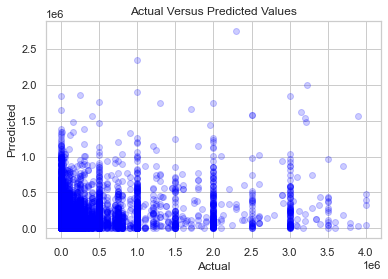

In [4]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.show() 

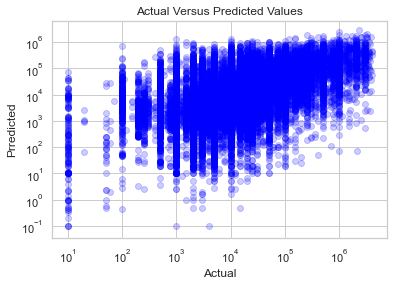

In [5]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

20


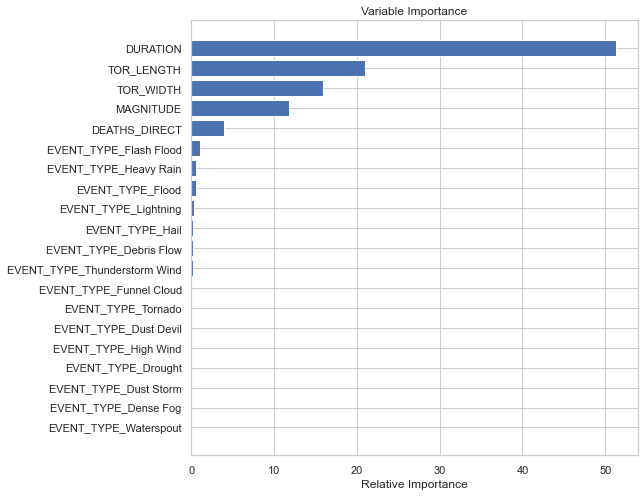

In [6]:
feature_importance = rf_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Now hyperparameter tuning

In [7]:
# set the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 9],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [5, 10, 20, 50, 100]
}

In [8]:
#markdown since it takes so long to run
# %%time
# random_search = RandomizedSearchCV(RandomForestRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [9]:
rf_reg_cv = RandomForestRegressor(max_depth=6, max_features=None, min_samples_leaf=10,
                      n_estimators=150, random_state=1234, n_jobs=-1)
rf_reg_cv.fit(X_train, y_train.values.ravel())

y_pred = rf_reg_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = rf_reg_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

TRAIN:
MAE:  27,156.7
MSE:  17,531,346,006.1
RMSE: 132,406.0
MAPE:  44,126,099,925,681,176,576.0

TEST:
MAE:  27,739.1
MSE:  19,479,915,783.7
RMSE: 139,570.5
MAPE:  43,130,760,644,746,690,560.0

MAE DIFF: 2%


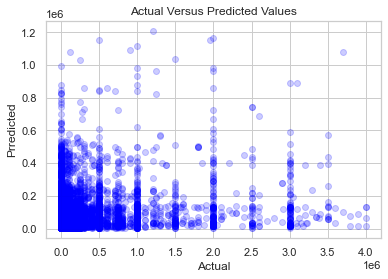

In [10]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.show() 

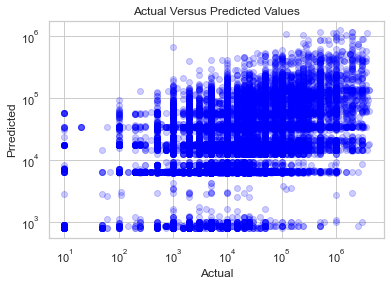

In [11]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

20


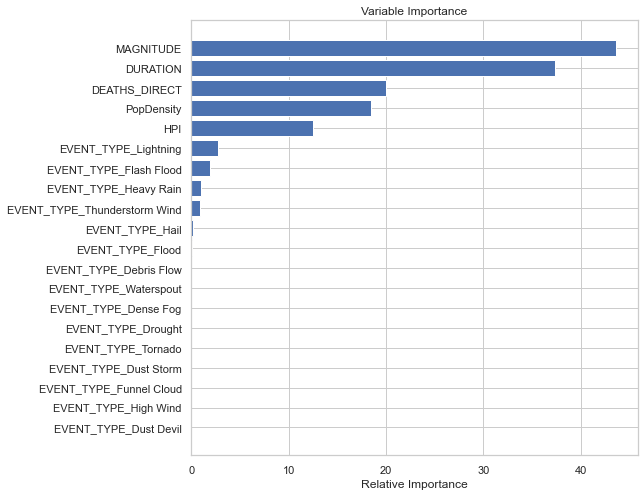

In [12]:
feature_importance = rf_reg_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# <font color='orange'>Light GBM</font>

In [13]:
# define the model
lgbm = LGBMRegressor(random_state=1234)
lgbm.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

y_pred = lgbm.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = lgbm.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

[1]	training's l2: 1.9293e+10	valid_1's l2: 2.11677e+10
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 1.90137e+10	valid_1's l2: 2.09086e+10
[3]	training's l2: 1.87819e+10	valid_1's l2: 2.06827e+10
[4]	training's l2: 1.8584e+10	valid_1's l2: 2.04828e+10
[5]	training's l2: 1.84134e+10	valid_1's l2: 2.03144e+10
[6]	training's l2: 1.827e+10	valid_1's l2: 2.01809e+10
[7]	training's l2: 1.81526e+10	valid_1's l2: 2.00548e+10
[8]	training's l2: 1.80443e+10	valid_1's l2: 1.99573e+10
[9]	training's l2: 1.79411e+10	valid_1's l2: 1.98694e+10
[10]	training's l2: 1.7846e+10	valid_1's l2: 1.97904e+10
[11]	training's l2: 1.77532e+10	valid_1's l2: 1.97099e+10
[12]	training's l2: 1.76764e+10	valid_1's l2: 1.96522e+10
[13]	training's l2: 1.7619e+10	valid_1's l2: 1.96061e+10
[14]	training's l2: 1.75653e+10	valid_1's l2: 1.95698e+10
[15]	training's l2: 1.75177e+10	valid_1's l2: 1.95361e+10
[16]	training's l2: 1.74733e+10	valid_1's l2: 1.95087e+10
[17]	training's l2: 1.7434

Text(0, 0.5, 'Predicted')

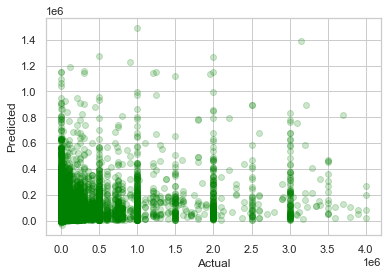

In [14]:
plt.scatter(y_test, y_pred, c='green', alpha=0.2)
plt.xlabel("Actual")
plt.ylabel("Predicted")

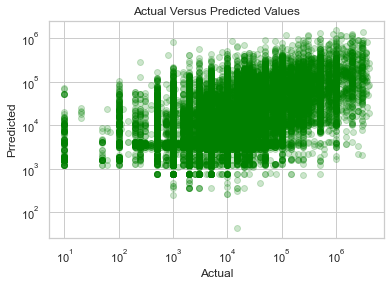

In [15]:
plt.scatter(y_test, y_pred, color = 'green', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

20


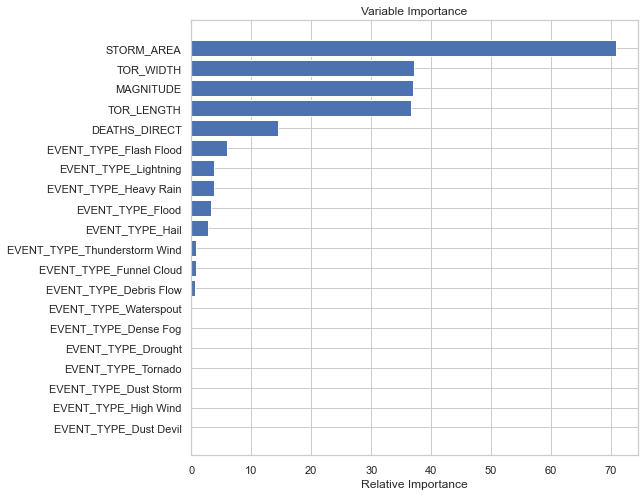

In [16]:
feature_importance = lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

With this baseline, let's see how we can improve with hyperparameter tuning

In [17]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'num_leaves': [10, 30, 50],
    'colsample_bytree': [.3, .5, .8]
}

In [18]:
# %%time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(LGBMRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [19]:
# define the model with hyperparamters from random search
lgbm_cv = LGBMRegressor(colsample_bytree=0.5, max_depth=9, n_estimators=150,
              num_leaves=30, random_state=1234)
lgbm_cv.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

y_pred = lgbm_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = lgbm_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

[1]	training's l2: 1.94443e+10	valid_1's l2: 2.12989e+10
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 1.92047e+10	valid_1's l2: 2.10565e+10
[3]	training's l2: 1.90328e+10	valid_1's l2: 2.08868e+10
[4]	training's l2: 1.88583e+10	valid_1's l2: 2.07478e+10
[5]	training's l2: 1.86778e+10	valid_1's l2: 2.06036e+10
[6]	training's l2: 1.85197e+10	valid_1's l2: 2.04386e+10
[7]	training's l2: 1.83975e+10	valid_1's l2: 2.031e+10
[8]	training's l2: 1.82835e+10	valid_1's l2: 2.01862e+10
[9]	training's l2: 1.81629e+10	valid_1's l2: 2.00686e+10
[10]	training's l2: 1.80576e+10	valid_1's l2: 1.9961e+10
[11]	training's l2: 1.79775e+10	valid_1's l2: 1.9894e+10
[12]	training's l2: 1.78998e+10	valid_1's l2: 1.98156e+10
[13]	training's l2: 1.784e+10	valid_1's l2: 1.97635e+10
[14]	training's l2: 1.77688e+10	valid_1's l2: 1.96963e+10
[15]	training's l2: 1.77164e+10	valid_1's l2: 1.96668e+10
[16]	training's l2: 1.76695e+10	valid_1's l2: 1.96326e+10
[17]	training's l2: 1.7624

[145]	training's l2: 1.60414e+10	valid_1's l2: 1.89535e+10
[146]	training's l2: 1.60332e+10	valid_1's l2: 1.89532e+10
[147]	training's l2: 1.60269e+10	valid_1's l2: 1.89539e+10
[148]	training's l2: 1.60245e+10	valid_1's l2: 1.8952e+10
[149]	training's l2: 1.60184e+10	valid_1's l2: 1.89507e+10
[150]	training's l2: 1.6014e+10	valid_1's l2: 1.89508e+10
Did not meet early stopping. Best iteration is:
[150]	training's l2: 1.6014e+10	valid_1's l2: 1.89508e+10
TRAIN:
MAE:  25,861.7
MSE:  16,013,959,656.3
RMSE: 126,546.3
MAPE:  41,271,781,191,631,314,944.0

TEST:
MAE:  26,861.2
MSE:  18,950,807,357.8
RMSE: 137,661.9
MAPE:  40,737,471,182,046,167,040.0

MAE DIFF: 4%


Text(0, 0.5, 'Predicted')

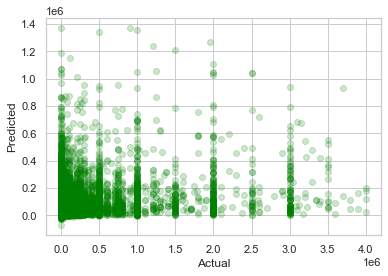

In [20]:
plt.scatter(y_test, y_pred, c='green', alpha=0.2)
plt.xlabel("Actual")
plt.ylabel("Predicted")

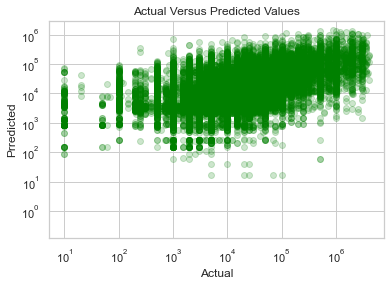

In [21]:
plt.scatter(y_test, y_pred, color = 'green', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

20


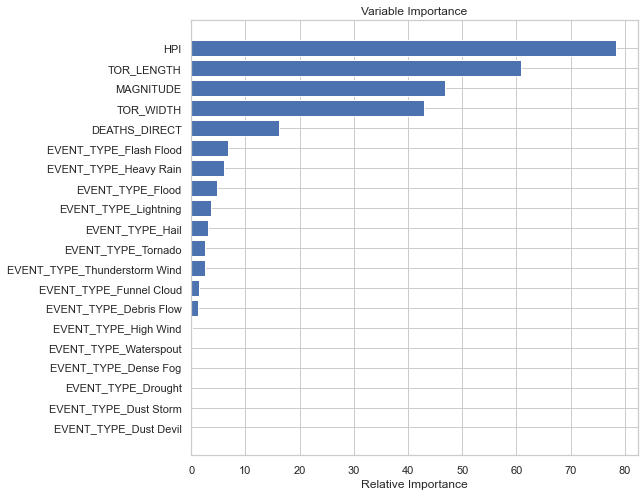

In [22]:
feature_importance = lgbm_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# <font color='orange'>XGBoost</font>


In [23]:
# define the model
xgbr = XGBRegressor(random_state=1234, early_stopping_rounds=20)
xgbr.fit(X_train, y_train, eval_set=eval_set)

y_pred = xgbr.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = xgbr.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

[0]	validation_0-rmse:137233.72596	validation_1-rmse:144370.37354
[1]	validation_0-rmse:134855.23864	validation_1-rmse:142384.07718
[2]	validation_0-rmse:133240.66708	validation_1-rmse:141039.70587
[3]	validation_0-rmse:132212.01622	validation_1-rmse:140475.57607
[4]	validation_0-rmse:131390.09751	validation_1-rmse:139943.73310
[5]	validation_0-rmse:130786.42745	validation_1-rmse:139695.93983
[6]	validation_0-rmse:130207.01792	validation_1-rmse:139398.05983
[7]	validation_0-rmse:129739.48495	validation_1-rmse:139311.20049
[8]	validation_0-rmse:129344.15267	validation_1-rmse:139135.75214
[9]	validation_0-rmse:128833.70922	validation_1-rmse:139012.44537
[10]	validation_0-rmse:128622.19784	validation_1-rmse:138986.23848
[11]	validation_0-rmse:128253.24052	validation_1-rmse:138953.50284
[12]	validation_0-rmse:127820.02340	validation_1-rmse:138909.08982
[13]	validation_0-rmse:127675.24260	validation_1-rmse:138896.60066
[14]	validation_0-rmse:127562.46562	validation_1-rmse:138891.37692
[15]	

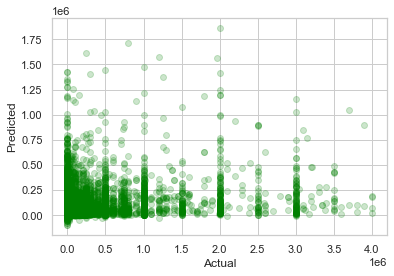

In [24]:
plt.scatter(y_test, y_pred, c='green', alpha=0.2)
plt.xlabel("Actual")
plt.ylabel("Predicted");

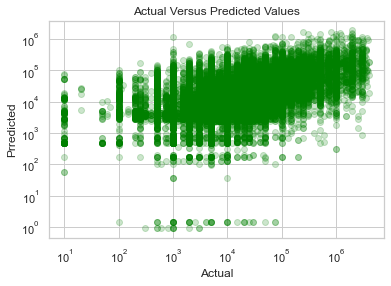

In [25]:
plt.scatter(y_test, y_pred, color = 'green', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

20


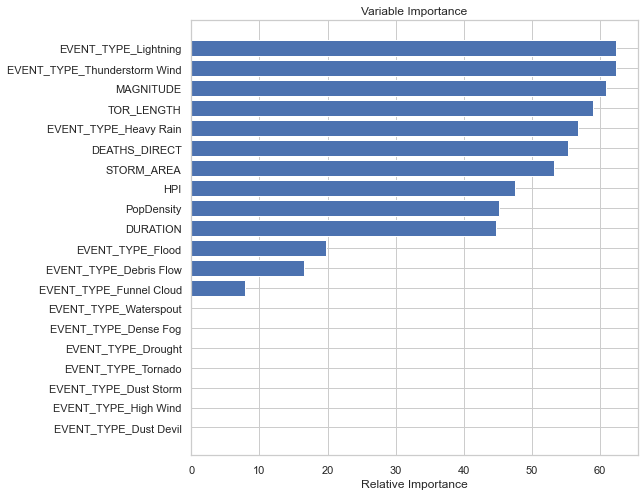

In [26]:
feature_importance = xgbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [27]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'colsample_bytree': [.3, .5, .8],
    'subsample': [.3, .5, .8]
}

In [28]:
# %%time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(XGBRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel(), eval_set=eval_set)
# print(random_search.best_estimator_)

In [29]:
# define the model
xgbr_cv = XGBRegressor(random_state=1234,
                       learning_rate=0.1, 
                       max_depth=6, 
                       n_estimators=150,
                       colsample_bytree=.8,
                       subsample=.8)

xgbr_cv.fit(X_train, y_train, eval_set=eval_set)

y_pred = xgbr_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = xgbr_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

[0]	validation_0-rmse:139819.59785	validation_1-rmse:146626.32358
[1]	validation_0-rmse:138636.28297	validation_1-rmse:145548.46927
[2]	validation_0-rmse:137651.47778	validation_1-rmse:144763.46486
[3]	validation_0-rmse:136744.67356	validation_1-rmse:143970.45137
[4]	validation_0-rmse:135984.39866	validation_1-rmse:143322.00619
[5]	validation_0-rmse:135350.65417	validation_1-rmse:142816.07098
[6]	validation_0-rmse:134882.23745	validation_1-rmse:142420.90920
[7]	validation_0-rmse:134388.06731	validation_1-rmse:142087.67621
[8]	validation_0-rmse:133941.21298	validation_1-rmse:141704.21229
[9]	validation_0-rmse:133520.85134	validation_1-rmse:141372.52315
[10]	validation_0-rmse:133081.56419	validation_1-rmse:141047.02529
[11]	validation_0-rmse:132747.15854	validation_1-rmse:140788.44536
[12]	validation_0-rmse:132403.34777	validation_1-rmse:140586.54239
[13]	validation_0-rmse:132149.49245	validation_1-rmse:140379.75363
[14]	validation_0-rmse:131880.77926	validation_1-rmse:140194.88580
[15]	

[123]	validation_0-rmse:123789.89067	validation_1-rmse:138079.55931
[124]	validation_0-rmse:123760.20764	validation_1-rmse:138053.52253
[125]	validation_0-rmse:123722.23819	validation_1-rmse:138044.23400
[126]	validation_0-rmse:123649.45444	validation_1-rmse:138033.57666
[127]	validation_0-rmse:123594.94324	validation_1-rmse:138030.94451
[128]	validation_0-rmse:123537.54935	validation_1-rmse:138025.26760
[129]	validation_0-rmse:123470.04033	validation_1-rmse:138035.02598
[130]	validation_0-rmse:123445.09204	validation_1-rmse:138035.30857
[131]	validation_0-rmse:123393.38586	validation_1-rmse:138020.04559
[132]	validation_0-rmse:123341.99813	validation_1-rmse:138026.31090
[133]	validation_0-rmse:123316.74917	validation_1-rmse:138032.44896
[134]	validation_0-rmse:123292.31771	validation_1-rmse:138033.49766
[135]	validation_0-rmse:123272.68091	validation_1-rmse:138027.48842
[136]	validation_0-rmse:123234.26595	validation_1-rmse:138048.17105
[137]	validation_0-rmse:123206.64795	validation_

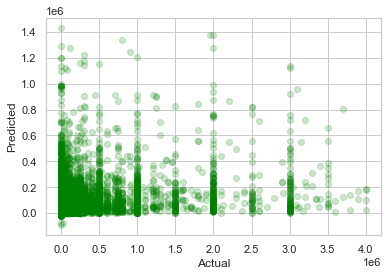

In [30]:
plt.scatter(y_test, y_pred, c='green', alpha=0.2)
plt.xlabel("Actual")
plt.ylabel("Predicted");

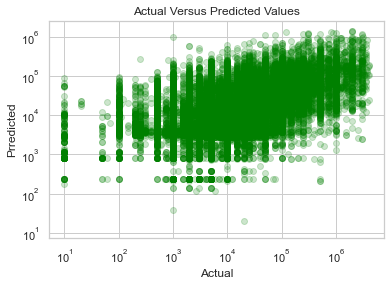

In [31]:
plt.scatter(y_test, y_pred, color = 'green', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

20


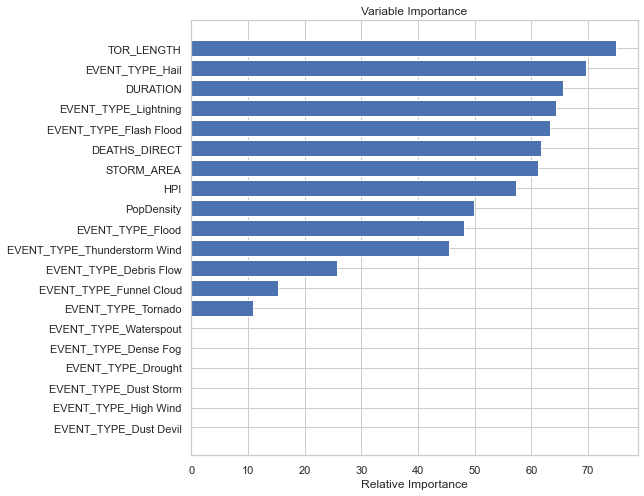

In [32]:
feature_importance = xgbr_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# <font color='orange'>Tweedie Regression</font>


Steps:
- Note: filter out claims with zero amount, as the severity model requires strictly positive target values.
- Correct for unreasonable observations (that might be data error) and a few exceptionally large claim amounts
    

In [33]:
# load the data - this dataset has the zeroes eliminated
### comment out since current run doesn't contain any zeroes nor outliers
# X_train = pd.read_parquet("../Data/X_train_td.pqt")
# X_test = pd.read_parquet("../Data/X_test_td.pqt")
# y_train = pd.read_parquet("../Data/y_train_td.pqt") 
# y_test = pd.read_parquet("../Data/y_test_td.pqt")

# X = pd.concat([X_train, X_test])
# y = pd.concat([y_train, y_test])

In [34]:
# tdrg = linear_model.TweedieRegressor(max_iter=500)
tdrg = TweedieRegressor(max_iter=500)
tdrg.fit(X_train, y_train.values.ravel())
# make predictions for test data
y_pred = tdrg.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
#train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = tdrg.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
#test_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
#print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

TRAIN:
MAE:  29,731.2
MSE:  18,761,667,052.4
RMSE: 136,973.2
MAPE:  53,656,119,866,403,594,240.0

TEST:
MAE:  30,585.3
MSE:  20,554,164,253.5
RMSE: 143,367.2
MAPE:  53,734,268,675,745,955,840.0

MAE DIFF: 3%


Text(0, 0.5, 'Predicted')

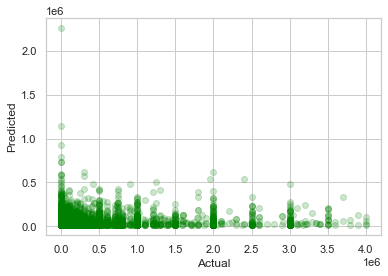

In [35]:
plt.scatter(y_test, y_pred, c='green', alpha=0.2)
plt.xlabel("Actual")
plt.ylabel("Predicted")

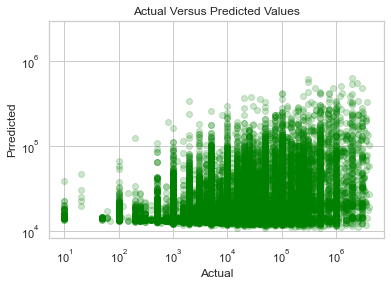

In [36]:
plt.scatter(y_test, y_pred, color = 'green', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

In [37]:
param_grid = {
    'power': [0, 1, 2, 3],
    'max_iter': [50, 100, 150, 200, 250, 500, 1000, 1500]
}

In [38]:
# %time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(linear_model.TweedieRegressor(),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [39]:
#tdrg_cv = TweedieRegressor(link='log', power=3, max_iter=50)
# tdrg = linear_model.TweedieRegressor(max_iter=500)
tdrg_cv = TweedieRegressor(link='log', power=1, max_iter=50)
tdrg_cv.fit(X_train, y_train.values.ravel())

# make predictions for test data
y_pred = tdrg_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
#train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = tdrg_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
#test_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
#print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

TRAIN:
MAE:  28,632.3
MSE:  21,214,757,722.9
RMSE: 145,652.9
MAPE:  48,098,315,743,513,550,848.0

TEST:
MAE:  29,326.4
MSE:  22,392,103,135.6
RMSE: 149,639.9
MAPE:  47,545,834,850,636,283,904.0

MAE DIFF: 2%


/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Text(0, 0.5, 'Predicted')

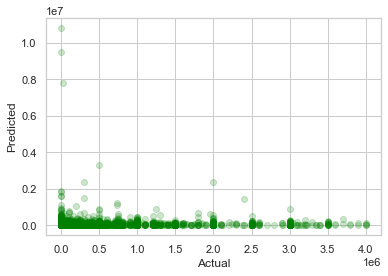

In [40]:
plt.scatter(y_test, y_pred, c='green', alpha=0.2)
plt.xlabel("Actual")
plt.ylabel("Predicted")

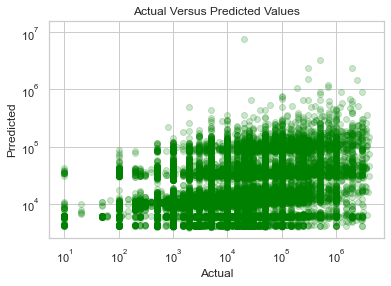

In [41]:
plt.scatter(y_test, y_pred, color = 'green', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

# check if resetting index changes any of these scores

##  <font color='red'>Scratch</font>


## WORKING, MARKDOWN UNTIL FINAL


for dimensionality reduction:
    lasso, ridge